In [184]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from tabulate import tabulate
from hyperopt import hp, fmin, tpe, Trials, space_eval
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
import cvxpy as cvx
from sklearn import metrics
from sklearn.metrics.pairwise import manhattan_distances
import quadprog
from sklearn.preprocessing import LabelEncoder
from bayes_opt import BayesianOptimization

In [3]:
# Load datasets
train_incubator = pd.read_csv('train_incubator.csv')
test_sf2 = pd.read_csv('test_sf2.csv')

# Check number of examples per class
print (train_incubator['class'].value_counts())
print (test_sf2['class'].value_counts())

nclasses = len(train_incubator['class'].unique())

class
arabiensis_female    3000
culex_female         3000
funestus_female      3000
gambiae_female       3000
Name: count, dtype: int64
class
gambiae_female       600
culex_female         522
funestus_female      512
arabiensis_female    428
Name: count, dtype: int64


In [190]:
# Define feature sets
special_features = ['temperature', 'duration', 'humidity', 'hour', 'luminosity', 'altitude', 'air_pressure']
wbf_features = ['L_harmcherry_wbf_mean','L_harmcherry_wbf_stddev']
freq_features = [f'L_harmcherry_h{i}_freq' for i in range(1,9)]
basefreq_features = [f'L_harmcherry_h{i}_basefreq' for i in range(1,9)]
relbasefreq_features = [f'L_harmcherry_h{i}_relbasefreq' for i in range(1,9)]
power_features = [f'L_harmcherry_h{i}_power' for i in range(1,9)]
relpower_features = [f'L_harmcherry_h{i}_relpower' for i in range(1,9)]
invented_features = [f'L_harmcherry_h{i}_invented' for i in range(1,9)]

In [194]:
# Train and test a LGBM model
feature_set = special_features+wbf_features+freq_features+basefreq_features+relbasefreq_features+power_features
X_train = pd.DataFrame(train_incubator, columns=feature_set)
X_train = pd.DataFrame(train_incubator, columns=feature_set)
y_train = train_incubator['class'].values 

X_test = pd.DataFrame(test_sf2, columns=feature_set)
y_test = test_sf2['class'].values

best_params = {'learning_rate': 0.14, 
                'max_depth': 9, 
                'n_estimators': 212,
                'colsample_bytree': 0.82,
                'num_leaves': 49,
                'reg_alpha': 0.077,
                'reg_lambda': 0.7,
                'subsample': 0.93}

models = [('LGBM', lgb.LGBMClassifier(**best_params))]

for name, model in models:
    print("Model: ", name)
    
    model.fit(X_train, y_train)
    
    p_labels = model.predict(X_test)
    a_labels = y_test
    acc = accuracy_score(a_labels, p_labels)
    
    print("\tAcc: %.4f" % acc)
    print (classification_report(a_labels, p_labels, labels=np.unique(y_test)))
        
    cf = confusion_matrix(a_labels, p_labels, labels=np.unique(y_train))
    print(tabulate(cf, headers=np.unique(y_train), tablefmt='fancy_grid'))

Model:  LGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 41
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

### Bayesian hyperparameter tuning

In [23]:
feature_set = special_features+wbf_features+freq_features+basefreq_features+relbasefreq_features+power_features

X = pd.DataFrame(train_incubator, columns=feature_set)
y = train_incubator['class'].values
groups = train_incubator['sensor'].values
# Select evaluation indicators
scoring = 'accuracy'

# Define parameter space
param_space = {
    'max_depth': hp.choice('max_depth', [3, 4, 5]),
    'num_leaves': hp.choice('num_leaves', [5, 6, 7, 12, 13, 14, 15, 28, 29, 30, 31]),
    'subsample': hp.choice('subsample', [0.8, 0.9, 1.0]),
    'colsample_bytree': hp.choice('colsample_bytree', [0.8, 0.9, 1.0]),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.01), np.log(1000)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.01), np.log(1000))
}

# Define objective function
def objective(params, X, y, groups):
    model = lgb.LGBMClassifier(**params)
    group_kfold = GroupKFold(n_splits=5)
    accuracies = []
    for train_index, test_index in group_kfold.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit model
        model.fit(X_train, y_train)

        # make predictions
        y_pred = model.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    # Returns the average cross-validation accuracy (negative value because fmin minimizes the objective function)
    return -np.mean(accuracies)
    

# Perform Bayesian optimization parameter tuning
trials = Trials()
best = fmin(lambda params: objective(params, X, y, groups),
            param_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

# Get the best parameter combination
best_params = space_eval(param_space, best)

# Calculate the accuracy rate under the best parameter combination
best_model = lgb.LGBMClassifier(**best_params)
best_accuracy = -objective(best_params, X, y, groups)

print("Best parameters found: ", best_params)
print("Best accuracy found: ", best_accuracy)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9466                     
[LightGBM] [Info] Number of data points in the train set: 9395, number of used features: 39
[LightGBM] [Info] Start training from score -1.379823 
[LightGBM] [Info] Start training from score -1.321889 
[LightGBM] [Info] Start training from score -1.412937 
[LightGBM] [Info] Start training from score -1.434148 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

### Print multi-error curve

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8981
[LightGBM] [Info] Number of data points in the train set: 9395, number of used features: 37
[LightGBM] [Info] Start training from score -1.379823
[LightGBM] [Info] Start training from score -1.321889
[LightGBM] [Info] Start training from score -1.412937
[LightGBM] [Info] Start training from score -1.434148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8972
[LightGBM] [Info] Number of data points in the train set: 9638, number of used features: 37
[LightGBM] [Info] Start training from score -1.430199
[LightGBM] [Info] Start training from score -1.406205
[LightGBM] [Info] Start training from score -1.335126
[LightGBM] [Info] Start training from score -1

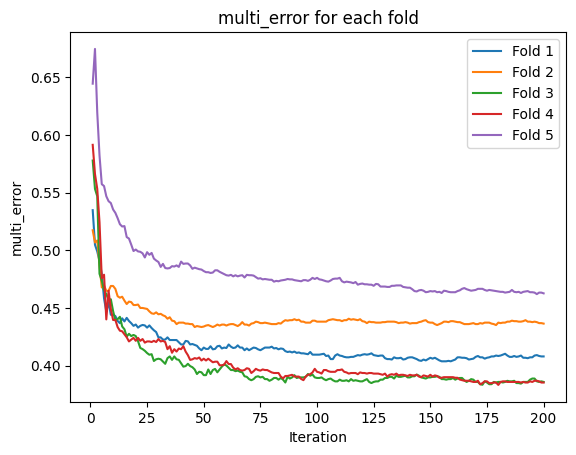

Average multi_error:  0.5842650631096031


In [6]:
# Define optimal parameters
best_params = {'learning_rate': 0.13, 
                'max_depth': 7, 
                'n_estimators': 200,
                'colsample_bytree': 0.8,
                'num_leaves': 5,
                'reg_alpha': 0.01,
                'reg_lambda': 0.01,
                'subsample': 0.88}

feature_set = special_features+wbf_features+freq_features+basefreq_features+relbasefreq_features+power_features

X = pd.DataFrame(train_incubator, columns=feature_set)
y = train_incubator['class'].values
groups = train_incubator['sensor'].values

# Create a model and set optimal parameters
model = lgb.LGBMClassifier(**best_params)

# Redefine the GroupKFold object to ensure the same grouping method is used
group_kfold = GroupKFold(n_splits=5)

# Create a multi_error_scores list to store the multi_error score of each fold
multi_error_scores = []

for fold_idx, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups=groups), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='multi_error')
    p_labels = model.predict(X_test)
    acc = accuracy_score(y_test, p_labels)
    multi_error_scores.append(acc)

    eval_results = model.evals_result_
    plt.plot(range(1, len(eval_results['valid_0']['multi_error']) + 1), eval_results['valid_0']['multi_error'], label=f"Fold {fold_idx}")

plt.xlabel('Iteration')
plt.ylabel('multi_error')
plt.title('multi_error for each fold')
plt.legend()
plt.show()

# Output the average of multi_error_scores
print("Average multi_error: ", sum(multi_error_scores) / len(multi_error_scores))


### Estimate the probability distribution for each class using different algorithms

In [80]:
def class_dist(Y, nclasses):
    return np.array([np.count_nonzero(Y == i) for i in range(nclasses)]) / Y.shape[0]

Y = train_incubator['class'].values
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

classes = class_dist(Y_encoded, nclasses)

print(np.unique(Y))
print(Y.shape[0])
print(classes)

['arabiensis_female' 'culex_female' 'funestus_female' 'gambiae_female']
12000
[0.25 0.25 0.25 0.25]


Use getScores to get the predicted score of train and test

Perform group cross-validation on the data through the group_kfold.split() method, where group_kfold is a defined group cross-validation object. In each iteration of cross-validation, use the fit() method to fit the model, and use the predict_proba() method to obtain the probability score of each sample belonging to each category, and then fill these scores into the corresponding positions of the train_scores array.

Finally, the model is refitted on the entire training set and the predict_proba() method is used to obtain the predicted probability score for the test set and stored in the test_scores array.

In [186]:
best_params = {'learning_rate': 0.14, 
                'max_depth': 9, 
                'n_estimators': 212,
                'colsample_bytree': 0.82,
                'num_leaves': 49,
                'reg_alpha': 0.077,
                'reg_lambda': 0.7,
                'subsample': 0.93}

def getScores(X_train, X_test, Y_train, nclasses):

    model = lgb.LGBMClassifier(**best_params)
    # model = lgb.LGBMClassifier()
   
    train_scores = np.zeros((len(X_train), nclasses))
    test_scores = np.zeros((len(X_test), nclasses))

    groups = train_incubator['sensor'].values

    for train_index, test_index in group_kfold.split(X, y, groups):
        model.fit(X_train[train_index], Y_train[train_index])
        train_scores[test_index] = model.predict_proba(X_train)[test_index]
    
    model.fit(X_train, Y_train)
    test_scores = model.predict_proba(X_test)
           
    return train_scores, test_scores

feature_set = special_features+wbf_features+freq_features+basefreq_features+relbasefreq_features+power_features

X_train = pd.DataFrame(train_incubator, columns=feature_set).values
X_test = pd.DataFrame(test_sf2, columns=feature_set).values
y_train = train_incubator['class'].values
groups = train_incubator['sensor'].values

train_scores, test_scores = getScores(X_train, X_test, y_train, nclasses)
print('train_scores')
print(train_scores)
print('test_scores')
print(test_scores)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9572
[LightGBM] [Info] Number of data points in the train set: 9395, number of used features: 41
[LightGBM] [Info] Start training from score -1.379823
[LightGBM] [Info] Start training from score -1.321889
[LightGBM] [Info] Start training from score -1.412937
[LightGBM] [Info] Start training from score -1.434148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

EMQ function

EM algorithm to estimate the class distribution of the test set. The EMQ function assumes that the class distribution of the test set is unknown, but can be estimated by the class conditional probabilities on the test set. It iteratively adjusts the class distribution so that, under given model parameters, the class conditional probability of the test set best matches the actual observed test set data.

In [198]:
alpha = 1

def EMQ(test_scores, train_labels, nclasses):
    max_it = 1000        # Max num of iterations
    eps = 1e-6           # Small constant for stopping criterium

    p_tr = class_dist(train_labels, nclasses)
    p_s = np.copy(p_tr)
    p_cond_tr = np.array(test_scores)
    p_cond_s = np.zeros(p_cond_tr.shape)

    for _ in range(max_it):
        # Add Laplacian smoothing
        # r = (p_s + alpha) / (p_tr + (alpha * nclasses))
        r = p_s / p_tr
        
        p_cond_s = p_cond_tr * r
        s = np.sum(p_cond_s, axis = 1)
        for c in range(nclasses):
            p_cond_s[:,c] = p_cond_s[:,c] / s
        
        p_s_old = np.copy(p_s)
        p_s = np.sum(p_cond_s, axis = 0) / p_cond_s.shape[0]
        if (np.sum(np.abs(p_s - p_s_old)) < eps):
            break

    return(p_s/np.sum(p_s))

    

Y = train_incubator['class'].values
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(Y)
# EMQ_result = EMQ(test_scores, train_labels, nclasses)
# print(EMQ_result)
X_train = pd.DataFrame(train_incubator, columns=feature_set).values
X_test = pd.DataFrame(test_sf2, columns=feature_set).values
y_train = train_incubator['class'].values
# groups = train_incubator['sensor'].values
lgbm_model = lgb.LGBMClassifier(**best_params)
lgbm_model.fit(X_train, y_train)
lgbm_probs = lgbm_model.predict_proba(X_test)
em_probs = EMQ(lgbm_probs, train_labels, nclasses)
print(em_probs)
final_probs = em_probs.argmax(axis=1)
print(final_probs)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 41
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

AxisError: axis 1 is out of bounds for array of dimension 1

GAC function(Generalized Adaptive Classification)

First, find the predicted class of each sample in the training and test data via np.argmax.

Then, a confusion matrix (Confusion Matrix) is constructed using the true class labels and predicted classes of the training data and transposed.

Next, calculate the frequency of each category in the test data.
To optimize, use the Convex Optimization Toolbox (cvxpy) to solve a minimization problem where the goal is to make the predicted class distribution as close as possible to the class distribution in the test data. This goal is achieved by minimizing the difference between the confusion matrix and the test data class distribution.

Finally, the optimized predicted class distribution is returned.

Train a classifier on the training data and optimize using the class distribution of the test data

In [91]:
def GAC(train_scores, test_scores, train_labels, nclasses):
   
    yt_hat = np.argmax(train_scores, axis = 1)
    y_hat = np.argmax(test_scores, axis = 1)
    CM = metrics.confusion_matrix(train_labels, yt_hat, normalize="true").T
    
    # Add Laplacian smoothing
    CM_smoothed = CM + nclasses

    p_y_hat = np.zeros(nclasses)
    values, counts = np.unique(y_hat, return_counts=True)
    p_y_hat[values] = counts 
    p_y_hat = p_y_hat/p_y_hat.sum()
    
    p_hat = cvx.Variable(CM_smoothed.shape[1])
    constraints = [p_hat >= 0, cvx.sum(p_hat) == 1.0]
    problem = cvx.Problem(cvx.Minimize(cvx.norm(CM_smoothed @ p_hat - p_y_hat)), constraints)
    problem.solve(solver=cvx.ECOS)
    return p_hat.value

GAC_result = GAC(train_scores, test_scores, train_labels, nclasses)
print(GAC_result)

[0.1781011  0.24453705 0.11099116 0.46637069]


GPAC function(Generalized Probabilistic Adaptive Classification)

GPAC models classification problems based on probabilistic models. It not only focuses on the relationship between the characteristics of samples and categories, but also considers the correlation between categories. By representing the relationships between categories as probability distributions, GPAC is able to more accurately capture the complexity of the data. It is also adaptive.

Use CVXPY to set up a convex optimization problem with the goal of making the predicted class distribution as close as possible to the class distribution of the test data. The optimization goal is to minimize the difference in probability distributions between classes. Use the ECOS solver to solve this convex optimization problem.

In [33]:
def GPAC(train_scores, test_scores, train_labels, nclasses):

    CM = np.zeros((nclasses, nclasses))
    for i in range(nclasses):
        idx = np.where(train_labels == i)[0]
        CM[i] = np.sum(train_scores[idx], axis=0)
        CM[i] /= np.sum(CM[i])
    CM = CM.T

    # Add Laplacian smoothing
    CM_smoothed = CM + nclasses

    p_y_hat = np.sum(test_scores, axis = 0)
    p_y_hat = p_y_hat / np.sum(p_y_hat)
    
    p_hat = cvx.Variable(CM_smoothed.shape[1])
    constraints = [p_hat >= 0, cvx.sum(p_hat) == 1.0]
    problem = cvx.Problem(cvx.Minimize(cvx.norm(CM_smoothed @ p_hat - p_y_hat)), constraints)
    problem.solve(solver=cvx.ECOS)
    return p_hat.value

GPAC_result = GPAC(train_scores, test_scores, train_labels, nclasses)
print(GPAC_result)

[0.50505895 0.19825174 0.00744496 0.28924435]


FM function(Feature Matching Classification)

The FM method focuses on the feature matching ratio, that is, the ratio of features in each class that is greater than the prior probability.
At the same time, the FM method uses the prior probability of each category in the training data to compare the characteristics of the sample with the prior probability to evaluate the importance of the sample characteristics.
FM methods also use convex optimization techniques and are adaptive

In [31]:
def FM(train_scores, test_scores, train_labels, nclasses):

    CM = np.zeros((nclasses, nclasses))
    y_cts = np.array([np.count_nonzero(train_labels == i) for i in range(nclasses)])
    p_yt = y_cts / train_labels.shape[0]
    for i in range(nclasses):
        idx = np.where(train_labels == i)[0]
        CM[:, i] += np.sum(train_scores[idx] > p_yt, axis=0) 
    CM = CM / y_cts

    p_y_hat = np.sum(test_scores > p_yt, axis = 0) / test_scores.shape[0]
    
    p_hat = cvx.Variable(CM.shape[1])
    constraints = [p_hat >= 0, cvx.sum(p_hat) == 1.0]
    problem = cvx.Problem(cvx.Minimize(cvx.norm(CM @ p_hat - p_y_hat)), constraints)
    problem.solve(solver=cvx.ECOS)
    return p_hat.value


FM_result = FM(train_scores, test_scores, train_labels, nclasses)
print(FM_result)

[0.34614494 0.19877053 0.02933074 0.4257538 ]


EDy function(Entropy Discretization)

The process of classification prediction based on the EDy method is performed by calculating the distance between samples and the corresponding category distribution.


In [29]:
def dpofa(m):
    r = np.array(m, copy=True)
    n = len(r)
    for k in range(n):
        s = 0.0
        if k >= 1:
            for i in range(k):
                t = r[i, k]
                if i > 0:
                    t = t - np.sum(r[0:i, i] * r[0:i, k])
                t = t / r[i, i]
                r[i, k] = t
                s = s + t * t
        s = r[k, k] - s
        if s <= 0.0:
            return k+1, r
        r[k, k] = np.sqrt(s)
    return 0, r

def nearest_pd(A):
    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if is_pd(A3):
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    indendity_matrix = np.eye(A.shape[0])
    k = 1
    while not is_pd(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += indendity_matrix * (-mineig * k ** 2 + spacing)
        k += 1

    return A3

def is_pd(m):
    return dpofa(m)[0] == 0


def solve_ed(G, a, C, b):
    sol = quadprog.solve_qp(G=G, a=a, C=C, b=b)
    prevalences = sol[0]
    # the last class was removed from the problem, its prevalence is 1 - the sum of prevalences for the other classes
    return np.append(prevalences, 1 - prevalences.sum())

def compute_ed_param_test(distance_func, train_distrib, test_distrib, K, classes, n_cls_i):

    n_classes = len(classes)
    Kt = np.zeros(n_classes)
    for i in range(n_classes):
        Kt[i] = distance_func(train_distrib[classes[i]], test_distrib).sum()

    Kt = Kt / (n_cls_i.squeeze() * float(len(test_distrib)))

    a = 2 * (- Kt[:-1] + K[:-1, -1] + Kt[-1] - K[-1, -1])
    return a

def compute_ed_param_train(distance_func, train_distrib, classes, n_cls_i):
    n_classes = len(classes)
    #  computing sum de distances for each pair of classes
    K = np.zeros((n_classes, n_classes))
    for i in range(n_classes):
        K[i, i] = distance_func(train_distrib[classes[i]], train_distrib[classes[i]]).sum()
        for j in range(i + 1, n_classes):
            K[i, j] = distance_func(train_distrib[classes[i]], train_distrib[classes[j]]).sum()
            K[j, i] = K[i, j]

    #  average distance
    K = K / np.dot(n_cls_i, n_cls_i.T)

    B = np.zeros((n_classes - 1, n_classes - 1))
    for i in range(n_classes - 1):
        B[i, i] = - K[i, i] - K[-1, -1] + 2 * K[i, -1]
        for j in range(n_classes - 1):
            if j == i:
                continue
            B[i, j] = - K[i, j] - K[-1, -1] + K[i, -1] + K[j, -1]

    #  computing the terms for the optimization problem
    G = 2 * B
    if not is_pd(G):
        G = nearest_pd(G)

    C = -np.vstack([np.ones((1, n_classes - 1)), -np.eye(n_classes - 1)]).T
    b = -np.array([1] + [0] * (n_classes - 1), dtype=float)

    return K, G, C, b

def EDy(tr_scores, labels, te_scores, nclasses):
    distance = manhattan_distances
    classes_ = np.unique(labels)
    train_distrib_ = dict.fromkeys(classes_)
    train_n_cls_i_ = np.zeros((nclasses, 1))
        
    if len(labels) == len(tr_scores):
            y_ext_ = labels
    else:
            y_ext_ = np.tile(labels, len(tr_scores) // len(labels))
        
    for n_cls, cls in enumerate(classes_):
        train_distrib_[cls] = tr_scores[y_ext_ == cls,:]
        train_n_cls_i_[n_cls, 0] = len(train_distrib_[cls])
        
    K_, G_, C_, b_ = compute_ed_param_train(distance, train_distrib_, classes_, train_n_cls_i_)
      
    a_ = compute_ed_param_test(distance, train_distrib_, te_scores, K_, classes_, train_n_cls_i_)

    prevalences = solve_ed(G=G_, a=a_, C=C_, b=b_)

    return prevalences/np.sum(prevalences)

EDy_result = EDy(train_scores, train_labels, test_scores, nclasses)
print(EDy_result)

[0.20536974 0.24638394 0.01963204 0.52861429]


### Test model accuracy

In [185]:
# Train and test a LGBM model
feature_set = special_features+wbf_features+freq_features+basefreq_features+relbasefreq_features+power_features

X_train = pd.DataFrame(train_incubator, columns=feature_set)
y_train = train_incubator['class'].values 

X_test = pd.DataFrame(test_sf2, columns=feature_set)
y_test = test_sf2['class'].values

# Define the evaluation function
def evaluate_model(learning_rate, max_depth, n_estimators, colsample_bytree, num_leaves, reg_alpha, reg_lambda, subsample):
    params = {
            'learning_rate': learning_rate,
            'max_depth': int(max_depth),
            'n_estimators': int(n_estimators),
            'colsample_bytree': colsample_bytree,
            'num_leaves': int(num_leaves),
            'reg_alpha': reg_alpha,
            'reg_lambda': reg_lambda,
            'subsample': subsample
        }

    model = lgb.LGBMClassifier(**params)

    # for name, model in models:
    print("Model: ", name)

    Y = train_incubator['class'].values
    label_encoder = LabelEncoder()
    train_labels = label_encoder.fit_transform(Y)
    EMQ_result = EMQ(test_scores, train_labels, nclasses)

    model.fit(X_train, y_train)

    p_labels = model.predict_proba(X_test)
    p_pred = []
    for item in p_labels:
        p_pred.append(np.argmax(item * EMQ_result))
    p_pred = label_encoder.inverse_transform(p_pred)

    a_labels = y_test
    acc = accuracy_score(a_labels, p_pred)
    return acc

# Define the parameter space
pbounds = {
    'learning_rate': (0.01, 0.2),
    'max_depth': (3, 10),
    'n_estimators': (100, 500),
    'colsample_bytree': (0.6, 1.0),
    'num_leaves': (4, 64),
    'reg_alpha': (0.0, 1.0),
    'reg_lambda': (0.0, 1.0),
    'subsample': (0.6, 1.0)
}

# Perform Bayesian optimization
optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=pbounds,
    random_state=42,
)

# Maximize the evaluation function
optimizer.maximize(init_points=5, n_iter=20)

# Get the best parameters
best_params = optimizer.max['params']
print("Best parameters:", best_params)

    # print("\tAcc: %.4f" % acc)
    # print (classification_report(a_labels, p_pred, labels=np.unique(y_test)))
         
    # cf = confusion_matrix(a_labels, p_pred, labels=np.unique(y_train))
    # print(tabulate(cf, headers=np.unique(y_train), tablefmt='fancy_grid'))

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
Model:  LGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 41
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

Init signature:
lgb.LGBMClassifier(
    boosting_type: str = 'gbdt',
    num_leaves: int = 31,
    max_depth: int = -1,
    learning_rate: float = 0.1,
    n_estimators: int = 100,
    subsample_for_bin: int = 200000,
    objective: Union[str, Callable[[Optional[numpy.ndarray], numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray], Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = None,
    class_weight: Union[Dict, str, NoneType] = None,
    min_split_gain: float = 0.0,
    min_child_weight: float = 0.001,
    min_child_samples: int = 20,
    subsample: float = 1.0,
    subsample_freq: int = 0,
    colsample_bytree: float = 1.0,
    reg_alpha: float = 0.0,
    reg_lambda: float = 0.0,
    random_state: Union[int, numpy.random.mtrand.RandomState, ForwardRef('np.random.Generat

In [193]:
# Train and test a LGBM model
feature_set = special_features+wbf_features+freq_features+basefreq_features+relbasefreq_features+power_features

X_train = pd.DataFrame(train_incubator, columns=feature_set)
y_train = train_incubator['class'].values 

X_test = pd.DataFrame(test_sf2, columns=feature_set)
y_test = test_sf2['class'].values

best_params = {'learning_rate': 0.14, 
                'max_depth': 9, 
                'n_estimators': 212,
                'colsample_bytree': 0.82,
                'num_leaves': 49,
                'reg_alpha': 0.077,
                'reg_lambda': 0.7,
                'subsample': 0.93}

model = lgb.LGBMClassifier(**best_params)
# model = lgb.LGBMClassifier()

# for name, model in models:
print("Model: ", name)

Y = train_incubator['class'].values
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(Y)
EMQ_result = EMQ(test_scores, train_labels, nclasses)

model.fit(X_train, y_train)

p_labels = model.predict_proba(X_test)
p_pred = []
for item in p_labels:
    p_pred.append(np.argmax(item * EMQ_result))
p_pred = label_encoder.inverse_transform(p_pred)

a_labels = y_test
acc = accuracy_score(a_labels, p_pred)

print("\tAcc: %.4f" % acc)
# print (classification_report(a_labels, p_pred, labels=np.unique(y_test)))
      
# cf = confusion_matrix(a_labels, p_pred, labels=np.unique(y_train))
# print(tabulate(cf, headers=np.unique(y_train), tablefmt='fancy_grid'))

Model:  LGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9591
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 41
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 